## Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

## Creating a helper function

In previous notebook, we've created a bunch of helper function, now we could rewrite them all, however, this is tedious.

So, it'a good idea to put function you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the function we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-16 13:19:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-16 13:19:52 (21.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import helper function we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you're runing this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`. so, you'll have redownload it if you want access to your helper functions. 

## Let's get some data 

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [3]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-02-16 13:19:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 108.177.111.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   179MB/s    in 0.9s    

2022-02-16 13:19:56 (179 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# Checkout how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [5]:
# Create training and test directory path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [6]:
import tensorflow as tf
IMG_SIZE=(224, 224)
BATCH_SIZE=32
train_data_10_percent =tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)
test_data =tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
# Checkout the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# See an example of batch data 
for images, labels in train_data_10_percent.take(1):
  print(images, labels)
   

tf.Tensor(
[[[[ 77.22959    51.22959    36.22959  ]
   [ 75.40306    49.40306    34.40306  ]
   [ 76.78062    50.780613   35.780613 ]
   ...
   [218.64293   200.64293   164.2144   ]
   [216.40308   198.40308   162.40308  ]
   [221.08669   203.08669   167.08669  ]]

  [[ 78.02551    52.02551    37.02551  ]
   [ 77.         51.         36.       ]
   [ 76.81632    50.816326   35.816326 ]
   ...
   [220.25517   202.25517   164.25517  ]
   [216.44899   198.44899   162.44899  ]
   [221.12238   203.12238   167.12238  ]]

  [[ 75.71939    52.719387   34.719387 ]
   [ 76.78571    53.785713   35.785713 ]
   [ 72.66326    49.663265   31.663265 ]
   ...
   [218.02556   200.02556   161.59698  ]
   [210.70407   192.70407   154.2755   ]
   [210.51518   192.51518   154.51518  ]]

  ...

  [[158.42859   144.42859   107.4286   ]
   [159.51535   145.51535   108.51535  ]
   [159.4031    145.4031    108.4031   ]
   ...
   [135.34216    99.535934   55.153313 ]
   [141.592     105.13273    60.14804  ]
   [1

## Model 0: Building a transfer learning model feature extraction using the Keras Functional API 

The sequential API is the straight-forward, it runs our layer in sequential order.

But the functional API give us more flexibilty with our models - https://www.tensorflow.org/guide/keras/functional

In [9]:
# 1. Create base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pretrained patterns aren't updated during training)
base_model.trainable = False

# 3. Create input into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. if using ResNet50V2 you will need to normalize inputs(you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model 
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most imortent information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="gobal_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer 
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8.  Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and Save its history
history_10_percent=model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25 *len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="10_percent_feature_extraction")])


16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220216-132012
Epoch 1/5
24/24 [==============================] - 30s 373ms/step - loss: 1.9664 - accuracy: 0.3667 - val_loss: 1.3808 - val_accuracy: 0.7253
Epoch 2/5
24/24 [==============================] - 7s 271ms/step - loss: 1.1803 - accuracy: 0.7320 - val_loss: 0.9305 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 7s 271ms/step - loss: 0.8534 - accuracy: 0.8053 - val_loss: 0.7234 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 9s 359ms/step - loss: 0.6940 - accuracy: 0.8400 - val_loss: 0.6444 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 7s 275ms/step - loss: 0.5990 - accuracy: 0.8560 - val_loss: 0.6001 - val_accuracy: 0.8586


In [10]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 12s 140ms/step - loss: 0.6091 - accuracy: 0.8444


[0.6091066598892212, 0.8443999886512756]

In [11]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [12]:
# How about we get a summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [13]:
# How about a summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gobal_average_pooling_layer  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


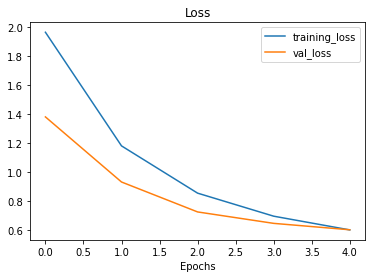

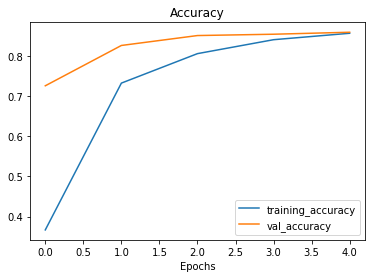

In [14]:
# Checkout our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from trained model

Let's demonstrate the Gloabel Average Pooling 2D layer...

we have a tensor after our model goes through `base_model` of shape(None, 7, 7, 1280).

But when it passes through GlobalAveragePooling2D, it turns into (None, 1280). 

Let's use similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [15]:
# Define the input shape
input_shape=(1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor throgh a global average pooling 2D layer
global_average_pooled_tensor =tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of different tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [16]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector**(a long tensor of number which represents the learned representation of model on particular sample, in our case, this is the output of the `tf.keras.layer.GlobalAveragePooling2D()` layer)which can then be used to extract patterns out of our own specific problem. 

## Runing a series of transfer learning experiments

we've seen the incredible results transfer learning can get with only 10% of the training data, but how does it goes with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the trainig data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of trainig data with data augmentation

**Note:** throughout all the experiments the same test dataset will be used to evaluate our model...this ensure consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [17]:
# Downlaod and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-02-16 13:21:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 209.85.145.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   130MB/s    in 1.0s    

2022-02-16 13:21:43 (130 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [18]:
# Creatr training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [19]:
# How many images we are working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [20]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE, # default = 32
                                                                           image_size=IMG_SIZE)

test_dir = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode="categorical",
                                                               image_size=IMG_SIZE,
                                                               batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into the model, we can use the layer inside:

* `tf.keras.experimental.preprocessing()`

we can see the benifits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation/

off the top of our heads, after reading the docs, the benifits of using the data augmnetation inside the model are:
* Preprocessing of images(augmented them) happens on the GPU (much faster) rather than as CPU.
* Image data augmentation only happens during training, so we can still export our whole modle and use it elsewhere. 

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation state with horizontal flipping, rotation, zoom etc.
data_augmentation = tf.keras.Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
  # preprocessing.Rescale(1./255) # keep for model like ResNet50V2 but for EfficientNet having rescaling built-in  
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)




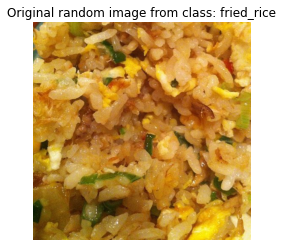

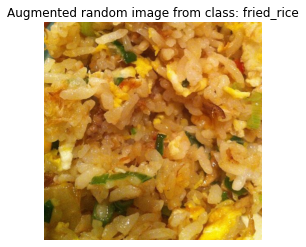

In [22]:
# View a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image 

# Read in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [23]:
# Setup input shape and base model, freezig the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input layers
inputs =layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential as model layer 
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x =base_model(x, training=False)

# Pool output feature of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent =model_1.fit(train_data_1_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_1_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25 *len(test_data)),
                               # Track model training logs
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220216-132148
Epoch 1/5
3/3 [==============================] - 17s 4s/step - loss: 2.3638 - accuracy: 0.1286 - val_loss: 2.2383 - val_accuracy: 0.1678
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1821 - accuracy: 0.2429 - val_loss: 2.1222 - val_accuracy: 0.2484
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9967 - accuracy: 0.3286 - val_loss: 2.0256 - val_accuracy: 0.3109
Epoch 4/5
3/3 [==============================] - 6s 3s/step - loss: 1.8211 - accuracy: 0.5143 - val_loss: 1.9324 - val_accuracy: 0.3766
Epoch 5/5
3/3 [==============================] - 8s 3s/step - loss: 1.6986 - accuracy: 0.6286 - val_loss: 1.8553 - val_accuracy: 0.4260


In [24]:
# Checkout a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [25]:
# Evaluating on the full test dataset
results_1_percent_data_Aug=model_1.evaluate(test_data)
results_1_percent_data_Aug

79/79 [==============================] - 14s 154ms/step - loss: 1.8365 - accuracy: 0.4252


[1.8364821672439575, 0.4251999855041504]

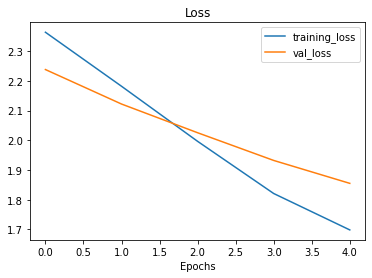

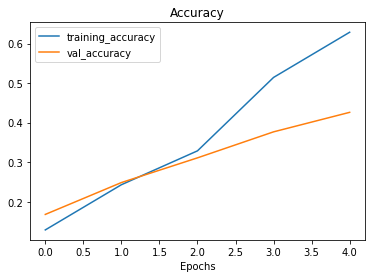

In [26]:
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [27]:
# Get 10% of the data..
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [28]:
# How many images are in our directory?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [29]:
# Setup a loaders
import tensorflow as tf
IMG_SIZE=(224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
# Create model_2 with data augmentation built-in
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Build data augmentaion layer
data_augmentation =tf.keras.Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
  #preprocessing.Rescaling(1./255)  # if you are using a model such as ResNet50V2, you'll need to rescale your data, Efficientnet having rescaling built in                              
], name="data_augmentation")

# Setup input shape to our model 
input_shape =(224, 224, 3)

# Create a frozen base model (also called backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layer in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (augmentation doesn't work on test data)
x = base_model(x, training=False) # Pass augmented images to base model but keep it in interface mode, this also insure our batchnorm layer dont get updated - https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit 


### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately save our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [31]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [32]:
# Fit the model saving checkpoint every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])
                                                                                 
                                          


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220216-132255
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0037 - accuracy: 0.3213
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 34s 908ms/step - loss: 2.0037 - accuracy: 0.3213 - val_loss: 1.4960 - val_accuracy: 0.6414
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3440 - accuracy: 0.6813
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 20s 790ms/step - loss: 1.3440 - accuracy: 0.6813 - val_loss: 1.0621 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0398 - accuracy: 0.7520
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 596ms/step - loss: 1.0398 - accuracy: 0.7520 - val_loss: 0.8610 - val_accuracy: 0.7862
E

In [33]:
# Check mode_2 results on all test_data set
results_10_percent_data_aug =model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 12s 140ms/step - loss: 0.6848 - accuracy: 0.8092


[0.6847948431968689, 0.8091999888420105]

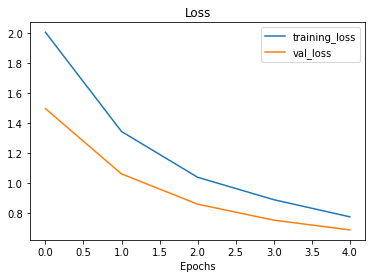

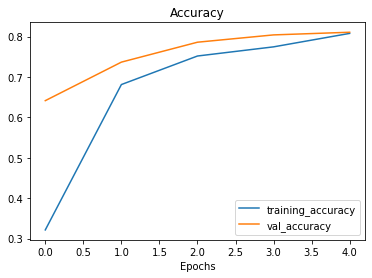

In [34]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint. 

In [35]:
# Load in save model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [36]:
# Evaluate model 2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 14s 166ms/step - loss: 0.6848 - accuracy: 0.8092


In [37]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

False

In [38]:
# Check to see if our loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [39]:
# Check the differecnce between two numbers
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

**Note:** Fine-tuning usually work best after training a feature extraction model for a few epochs with large amount of custom data.

In [40]:
# Layers in loaded model
model_2.layers

In [41]:
# Are these layer trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f34df7fe450> True
<keras.engine.sequential.Sequential object at 0x7f34df802cd0> True
<keras.engine.functional.Functional object at 0x7f34e09c2250> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f34e0d33150> True
<keras.layers.core.dense.Dense object at 0x7f34e08af550> True


In [42]:
# What layers are in our base_model (EfficienNetB0) are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [43]:
# How many trainable variables are in our base_model?
print(len(model_2.layers[2].trainable_variables))

0


In [44]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable=True
base_model.trainable=True

# Freeze all layer except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

# Recompile (we have to recompile every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # When fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])
  

**Note:** When using fine-tuning it's best practice to lower learning rate by some amount. How much? This is hyperperameter you can tune. But a good of rule of thumb is at least 10x(though differnt sources will claim values).
A good resource for information on this is the ULMFiT: https://arxiv.org/abs/1801.06146 

In [45]:
# Check which layer is tunable(trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [47]:
# Now we've unfrozen some of layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [49]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # Start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="trasfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10 ")])

Saving TensorBoard log files to: trasfer_learning/10_percent_fine_tune_last_10 /20220216-135714
Epoch 5/10
24/24 [==============================] - 29s 785ms/step - loss: 0.7191 - accuracy: 0.7840 - val_loss: 0.5264 - val_accuracy: 0.8388
Epoch 6/10
24/24 [==============================] - 15s 606ms/step - loss: 0.5768 - accuracy: 0.8320 - val_loss: 0.4890 - val_accuracy: 0.8388
Epoch 7/10
24/24 [==============================] - 14s 569ms/step - loss: 0.4754 - accuracy: 0.8533 - val_loss: 0.5028 - val_accuracy: 0.8339
Epoch 8/10
24/24 [==============================] - 14s 558ms/step - loss: 0.4454 - accuracy: 0.8720 - val_loss: 0.4492 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 14s 577ms/step - loss: 0.3779 - accuracy: 0.8960 - val_loss: 0.4803 - val_accuracy: 0.8273
Epoch 10/10
24/24 [==============================] - 14s 566ms/step - loss: 0.3880 - accuracy: 0.8773 - val_loss: 0.4529 - val_accuracy: 0.8306


In [51]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine_tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 12s 138ms/step - loss: 0.5045 - accuracy: 0.8248


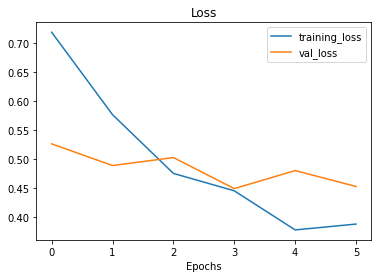

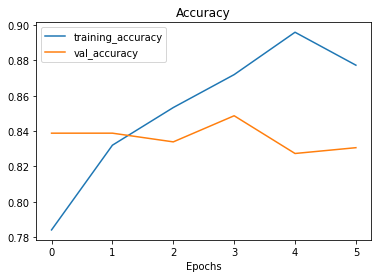

In [53]:
# Checkout the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with model which have been fit only once, however we want something to compare one series of runing `fit()` with one another (e.g. before and after fine-tuning).

In [54]:
# Let's create a function to compare training history
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compare two TensorFlow History objects.
  """
  # Get original history meaurments
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]
  # combine original history metrics with new history 
  total_val_acc = acc + new_history.history["val_accuracy"]
  total_val_loss = loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")


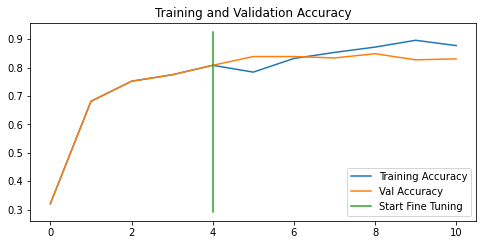

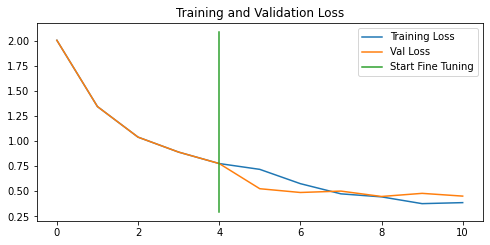

In [55]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning and existing model on all of the data

In [56]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-02-16 14:43:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 172.253.114.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   121MB/s    in 4.3s    

2022-02-16 14:43:23 (116 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [57]:
# Setup train and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [58]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [59]:
# Set up data inputs 
import tensorflow as tf
IMG_SIZE=(224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test data we've loaded in is same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [60]:
# Evaluate model_2 (this is fine-tuned on 10% of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 12s 143ms/step - loss: 0.5045 - accuracy: 0.8248


[0.5044717788696289, 0.8248000144958496]

In [61]:
results_fine_tune_10_percent

[0.5044717788696289, 0.8248000144958496]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [62]:
# Load weights from checkpoint, that way we can fine-tune from
# the same stage the 10 percent data model was fine-tuned from 
model_2.load_weights(checkpoint_path)

In [64]:
# Let's evaluate model 2 now
model_2.evaluate(test_data)

79/79 [==============================] - 12s 139ms/step - loss: 0.6848 - accuracy: 0.8092


[0.6847949028015137, 0.8091999888420105]

In [65]:
# Check to see if our model 2 reverted back to feature extraction results
results_10_percent_data_aug

[0.6847948431968689, 0.8091999888420105]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen(model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as step 2 except this time we're going to use all of the data.

In [68]:
# Check which layer is tunable in whole model
for layer_number, layer  in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [69]:
# Let's drill into our base model(efficientnetb0) and see what layer are trainable
for layer_number, layer  in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [70]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [71]:
# Continue to train and fine-tune the model to our data (100% of training data)
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1], # Start training from previous last epoch
                                           callbacks=[create_tensorboard_callback(dir_name="trasfer_learning",
                                                                                      experiment_name="full_10_classes_fine_tune_last_10 ")])

Saving TensorBoard log files to: trasfer_learning/full_10_classes_fine_tune_last_10 /20220216-152852
Epoch 5/10
235/235 [==============================] - 102s 386ms/step - loss: 0.7215 - accuracy: 0.7695 - val_loss: 0.4509 - val_accuracy: 0.8421
Epoch 6/10
235/235 [==============================] - 79s 334ms/step - loss: 0.5861 - accuracy: 0.8093 - val_loss: 0.3690 - val_accuracy: 0.8766
Epoch 7/10
235/235 [==============================] - 74s 312ms/step - loss: 0.5246 - accuracy: 0.8297 - val_loss: 0.3825 - val_accuracy: 0.8865
Epoch 8/10
235/235 [==============================] - 67s 283ms/step - loss: 0.4764 - accuracy: 0.8448 - val_loss: 0.3252 - val_accuracy: 0.9095
Epoch 9/10
235/235 [==============================] - 64s 273ms/step - loss: 0.4329 - accuracy: 0.8609 - val_loss: 0.3552 - val_accuracy: 0.8816
Epoch 10/10
235/235 [==============================] - 64s 271ms/step - loss: 0.4087 - accuracy: 0.8669 - val_loss: 0.3613 - val_accuracy: 0.8931


In [72]:
# Let's evaluate on all the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data 

79/79 [==============================] - 12s 146ms/step - loss: 0.3536 - accuracy: 0.8840


[0.3536369204521179, 0.8840000033378601]

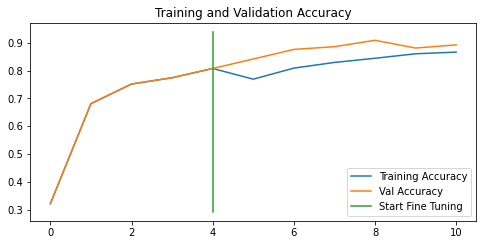

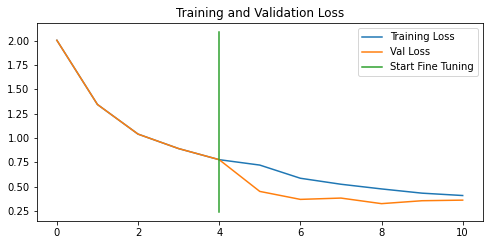

In [73]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on TensorBoard

**Note:** Anything you upload to Tensorboard.dev is going to be public.So if you have private data, do not upload.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments with 10 Food101 classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

My Tensorboard experiments are available at: https://tensorboard.dev/experiment/bqyjsLs5SDWUdZ4vgOuw3g/#scalars

In [75]:
# View previous experiments
!tensorboard dev list

https://tensorboard.dev/experiment/bqyjsLs5SDWUdZ4vgOuw3g/
	Name                 Transfer learning experiments with 10 Food101 classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   bqyjsLs5SDWUdZ4vgOuw3g
	Created              2022-02-16 15:48:01 (9 minutes ago)
	Updated              2022-02-16 15:48:04 (9 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  2539348
https://tensorboard.dev/experiment/SENB4NrLQjKfmMl0E3SwWA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          comparing two different TF Hub feature extraction model architecures using 10% of the training data
	Id                   SENB4NrLQjKfmMl0E3SwWA
	Created              2022-02-10 19:34:18
	Updated              2022-02-10 19:34:21
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0

In [76]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id SENB4NrLQjKfmMl0E3SwWA